In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.datasets import fetch_covtype
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import (
    cross_val_score,
    RepeatedStratifiedKFold,
    train_test_split,
    RepeatedKFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    f_regression,
    RFE,
    mutual_info_classif,
    mutual_info_regression
)
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

# Global random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
class GeFeS:
    """
    Generalized Feature Selection using Genetic Algorithm

    A wrapper-based feature selection method that uses genetic algorithms
    to optimize feature subsets for classification and regression tasks.
    """

    def __init__(self, estimator, population_size=50, generations=100,
                 crossover_rate=0.8, mutation_rate=0.1, elite_size=2,
                 cv_folds=5, scoring='accuracy', higher_is_better=True,
                 random_state=None, verbose=False):
        """
        Parameters:
        -----------
        estimator : sklearn estimator
            The machine learning model to use for evaluation (classifier or regressor)
        population_size : int
            Number of individuals in each generation
        generations : int
            Number of generations to evolve
        crossover_rate : float
            Probability of crossover (0-1)
        mutation_rate : float
            Probability of mutation for each gene (0-1)
        elite_size : int
            Number of best individuals to preserve unchanged
        cv_folds : int
            Number of cross-validation folds for fitness evaluation
        scoring : str or callable
            Scoring metric for evaluation. For classification: 'accuracy', 'precision',
            'recall', 'f1', 'roc_auc'. For regression: 'r2', 'neg_mean_squared_error',
            'neg_mean_absolute_error', 'neg_root_mean_squared_error'.
            Can also be a custom scorer.
        higher_is_better : bool
            Whether higher scores are better (True for accuracy, R2) or
            lower is better (False for MSE, MAE)
        random_state : int
            Random seed for reproducibility
        verbose : bool
            Print progress information
        """
        self.estimator = estimator
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.cv_folds = cv_folds
        self.scoring = scoring
        self.higher_is_better = higher_is_better
        self.random_state = random_state
        self.verbose = verbose

        self.best_features_ = None
        self.best_score_ = None
        self.fitness_history_ = []
        self.feature_names_ = None

        if random_state is not None:
            np.random.seed(random_state)

    def _initialize_population(self, n_features):
        """Create initial population with random binary chromosomes"""
        population = []
        for _ in range(self.population_size):
            # Ensure at least one feature is selected
            chromosome = np.random.randint(0, 2, n_features)
            if chromosome.sum() == 0:
                chromosome[np.random.randint(0, n_features)] = 1
            population.append(chromosome)
        return np.array(population)

    def _calculate_fitness(self, chromosome, X, y):
        """
        Evaluate fitness of a chromosome using cross-validation
        """
        selected_features = np.where(chromosome == 1)[0]

        if len(selected_features) == 0:
            return -np.inf if self.higher_is_better else np.inf

        X_subset = X[:, selected_features]

        try:
            # Cross-validation score
            scores = cross_val_score(
                clone(self.estimator),
                X_subset,
                y,
                cv=self.cv_folds,
                scoring=self.scoring
            )
            fitness = scores.mean()

        except Exception as e:
            fitness = -np.inf if self.higher_is_better else np.inf

        return fitness

    def _evaluate_population(self, population, X, y):
        """Evaluate fitness for entire population"""
        fitness_scores = []
        for chromosome in population:
            fitness = self._calculate_fitness(chromosome, X, y)
            fitness_scores.append(fitness)
        return np.array(fitness_scores)

    def _selection(self, population, fitness_scores):
        """Tournament selection"""
        tournament_size = 3
        selected = []

        for _ in range(self.population_size - self.elite_size):
            # Random tournament
            tournament_idx = np.random.choice(
                len(population),
                tournament_size,
                replace=False
            )
            tournament_fitness = fitness_scores[tournament_idx]

            # Select best based on optimization direction
            if self.higher_is_better:
                winner_idx = tournament_idx[np.argmax(tournament_fitness)]
            else:
                winner_idx = tournament_idx[np.argmin(tournament_fitness)]

            selected.append(population[winner_idx].copy())

        return np.array(selected)

    def _crossover(self, parent1, parent2):
        """Single-point crossover"""
        if np.random.random() < self.crossover_rate:
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate([parent1[:crossover_point],
                                    parent2[crossover_point:]])
            child2 = np.concatenate([parent2[:crossover_point],
                                    parent1[crossover_point:]])
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()

    def _mutate(self, chromosome):
        """Bit-flip mutation"""
        for i in range(len(chromosome)):
            if np.random.random() < self.mutation_rate:
                chromosome[i] = 1 - chromosome[i]

        # Ensure at least one feature is selected
        if chromosome.sum() == 0:
            chromosome[np.random.randint(0, len(chromosome))] = 1

        return chromosome

    def fit(self, X, y, feature_names=None):
        """
        Run genetic algorithm to find optimal feature subset

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        feature_names : list or array-like, optional
            Names of features. If None, features will be named as 'feature_0', 'feature_1', etc.
        """
        n_features = X.shape[1]

        # Store feature names
        if feature_names is not None:
            self.feature_names_ = np.array(feature_names)
        else:
            self.feature_names_ = np.array([f'feature_{i}' for i in range(n_features)])

        # Initialize population
        population = self._initialize_population(n_features)

        best_overall_fitness = -np.inf if self.higher_is_better else np.inf
        best_overall_chromosome = None

        for generation in range(self.generations):
            # Evaluate fitness
            fitness_scores = self._evaluate_population(population, X, y)

            # Track best solution based on optimization direction
            if self.higher_is_better:
                best_idx = np.argmax(fitness_scores)
                is_better = fitness_scores[best_idx] > best_overall_fitness
            else:
                best_idx = np.argmin(fitness_scores)
                is_better = fitness_scores[best_idx] < best_overall_fitness

            if is_better:
                best_overall_fitness = fitness_scores[best_idx]
                best_overall_chromosome = population[best_idx].copy()

            self.fitness_history_.append({
                'generation': generation,
                'best_fitness': fitness_scores[best_idx],
                'mean_fitness': fitness_scores.mean(),
                'n_features': population[best_idx].sum()
            })

            if self.verbose and generation % 10 == 0:
                print(f"Generation {generation}: "
                      f"Best={fitness_scores[best_idx]:.4f}, "
                      f"Mean={fitness_scores.mean():.4f}, "
                      f"Features={int(population[best_idx].sum())}")

            # Elitism: preserve best individuals
            if self.higher_is_better:
                elite_idx = np.argsort(fitness_scores)[-self.elite_size:]
            else:
                elite_idx = np.argsort(fitness_scores)[:self.elite_size]
            elite = population[elite_idx]

            # Selection
            selected = self._selection(population, fitness_scores)

            # Crossover and mutation
            offspring = []
            for i in range(0, len(selected) - 1, 2):
                child1, child2 = self._crossover(selected[i], selected[i + 1])
                child1 = self._mutate(child1)
                child2 = self._mutate(child2)
                offspring.extend([child1, child2])

            # Create new population
            offspring = np.array(offspring[:self.population_size - self.elite_size])
            population = np.vstack([elite, offspring])

        # Store best solution
        self.best_features_ = np.where(best_overall_chromosome == 1)[0]
        self.best_score_ = best_overall_fitness

        return self

    def transform(self, X):
        """Transform X to selected feature subset"""
        if self.best_features_ is None:
            raise ValueError("GeFeS has not been fitted yet!")
        return X[:, self.best_features_]

    def fit_transform(self, X, y, feature_names=None):
        """Fit and transform in one step"""
        self.fit(X, y, feature_names=feature_names)
        return self.transform(X)

    def get_support(self, indices=False):
        """Get selected features as boolean mask or indices"""
        if self.best_features_ is None:
            raise ValueError("GeFeS has not been fitted yet!")

        if indices:
            return self.best_features_
        else:
            mask = np.zeros(len(self.feature_names_), dtype=bool)
            mask[self.best_features_] = True
            return mask

    def get_feature_names(self):
        """Get names of selected features"""
        if self.best_features_ is None:
            raise ValueError("GeFeS has not been fitted yet!")
        return self.feature_names_[self.best_features_]

    def get_feature_importance_dict(self):
        """Get dictionary mapping selected feature names to their indices"""
        if self.best_features_ is None:
            raise ValueError("GeFeS has not been fitted yet!")
        return {name: idx for idx, name in zip(self.best_features_,
                                                self.feature_names_[self.best_features_])}

# Classification

FEATURE SELECTION COMPARISON FRAMEWORK

Loading Covertype dataset...
Fetching full dataset (this may take a moment)...
Full dataset size: 581012 samples, 54 features
Binary classification subset: 495141 samples

Final dataset shape: (1000, 54)
Number of samples: 1000
Number of features: 54
Number of classes: 2

Class distribution:
  Class 0 (Spruce/Fir): 428 samples (42.8%)
  Class 1 (Lodgepole Pine): 572 samples (57.2%)

✓ Dataset is well-balanced (ratio: 1.34:1)
→ Using Accuracy as primary metric
→ Also tracking F1-score, precision, recall, and ROC-AUC

📊 Dataset Context:
   - Covertype: Predicting forest cover type from cartographic variables
   - Binary task: Spruce/Fir (0) vs Lodgepole Pine (1)
   - Features include elevation, slope, distance to water, soil types, etc.
   - Real-world ecological classification problem

Running GeFeS (Genetic Algorithm)...
Generation 0: Best=0.7830, Mean=0.7027, Features=16
Generation 10: Best=0.7880, Mean=0.7633, Features=28
Generation 20: Best=0.

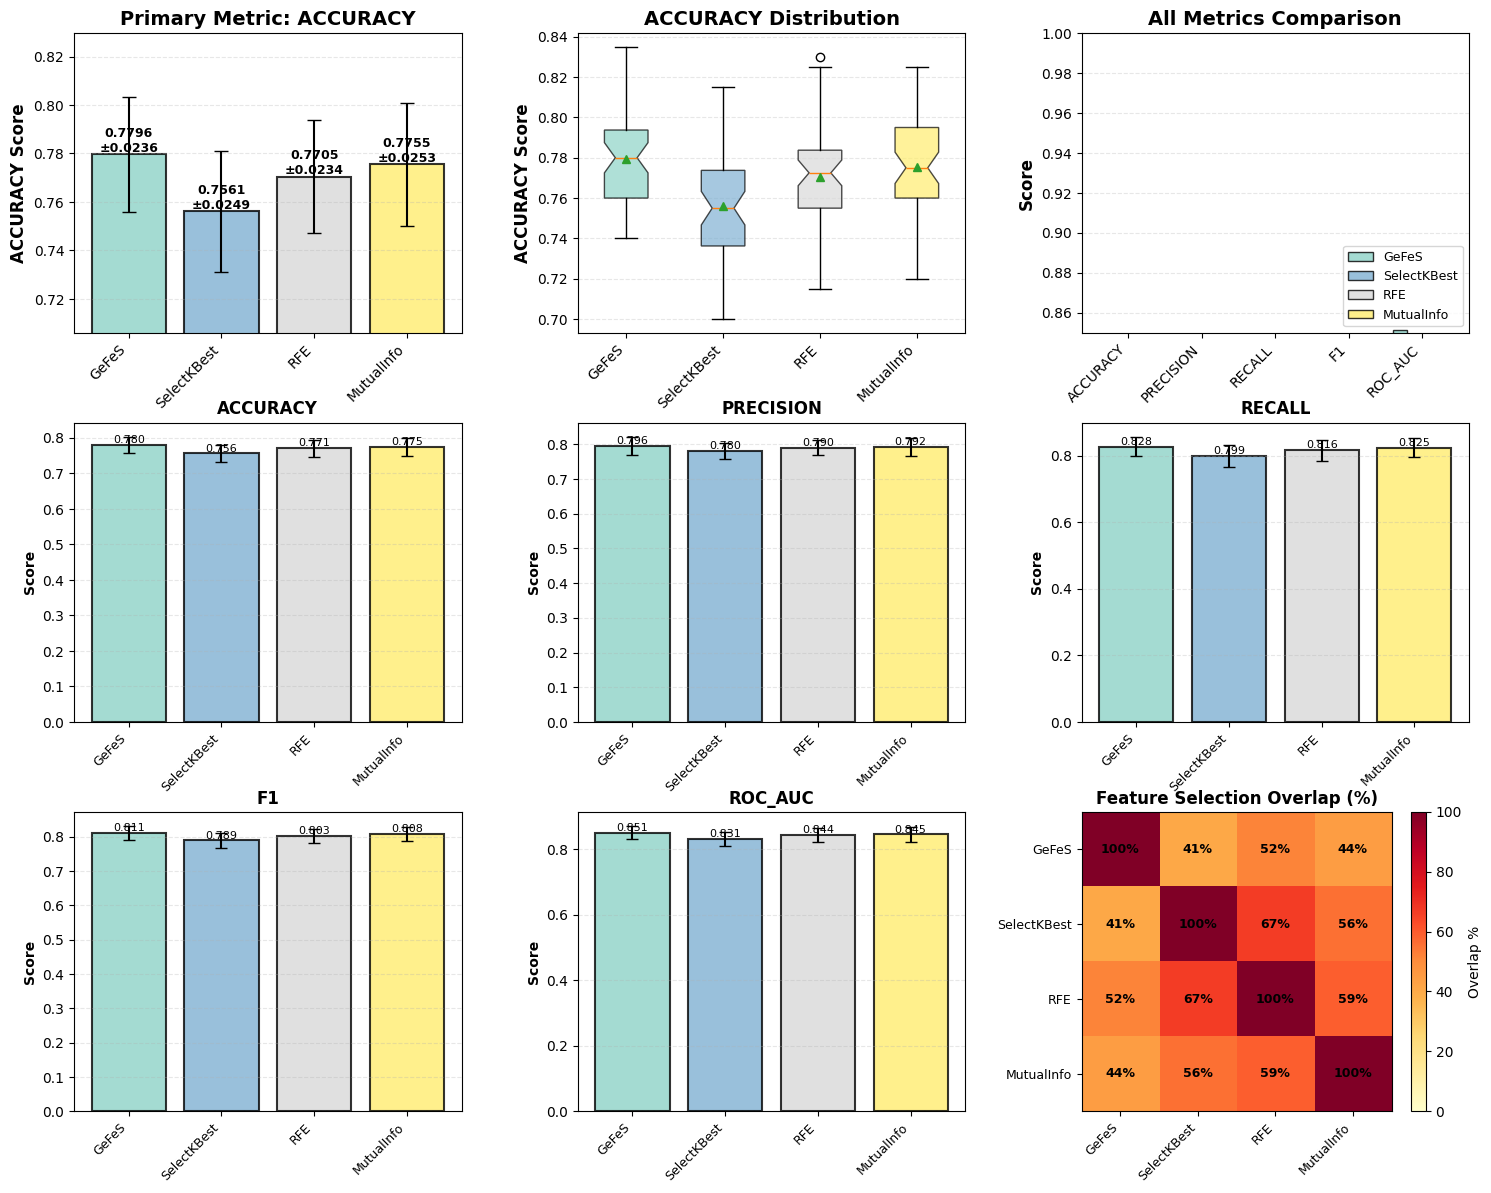


Analysis complete!


In [4]:
class FeatureSelectionComparison:
    """
    Compare multiple feature selection methods with statistical significance testing.

    IMPORTANT:
    ----------
    - GeFeS is run first and decides how many features are "optimal".
    - That number (k) is then used by SelectKBest, RFE, and Mutual Information
      so that all methods are compared with the SAME # of features.
    """

    def __init__(self, X, y, feature_names=None,
                 n_features_to_select=None,  # can be None; will be overwritten by GeFeS
                 estimator=None, n_repeats=10, cv_folds=5, primary_metric='accuracy'):
        self.X = X
        self.y = y
        self.feature_names = feature_names if feature_names is not None else \
            [f'Feature_{i}' for i in range(X.shape[1])]

        # This will be updated after running GeFeS
        self.n_features_to_select = n_features_to_select

        self.estimator = estimator if estimator is not None else \
            RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
        self.n_repeats = n_repeats
        self.cv_folds = cv_folds
        self.primary_metric = primary_metric

        self.results = {}
        self.selected_features = {}
        self.scores_distribution = {}
        self.all_metrics_scores = {}

    # ----------------- GeFeS -----------------

    def run_gefes(self):
        """Run GeFeS (Genetic Algorithm) feature selection"""
        print("\n" + "="*60)
        print("Running GeFeS (Genetic Algorithm)...")
        print("="*60)

        selector = GeFeS(
            estimator=self.estimator,
            population_size=30,
            generations=50,
            crossover_rate=0.8,
            mutation_rate=0.1,
            elite_size=2,
            cv_folds=self.cv_folds,
            scoring=self.primary_metric,
            higher_is_better=True,
            random_state=RANDOM_STATE,
            verbose=True
        )

        selector.fit(self.X, self.y, feature_names=self.feature_names)
        selected_features = selector.get_feature_names()

        # *** KEY LINE: Use GeFeS's feature count for all other methods ***
        self.n_features_to_select = len(selected_features)
        print(f"\n[GeFeS] Determined optimal number of features: {self.n_features_to_select}")
        print("         Other feature selection methods will use this same k.")

        all_metrics = self._evaluate_features_all_metrics(selector.best_features_)
        primary_scores = all_metrics[self.primary_metric]

        self.results['GeFeS'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            'best_score': selector.best_score_,
            **{f'{metric}_mean': np.mean(scores) for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores) for metric, scores in all_metrics.items()}
        }
        self.selected_features['GeFeS'] = list(selected_features)
        self.scores_distribution['GeFeS'] = primary_scores
        self.all_metrics_scores['GeFeS'] = all_metrics

        print(f"\nGeFeS Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric.upper()}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)
        print(f"  Top selected features: {', '.join(str(f) for f in selected_features[:8])}...")
        if len(selected_features) > 8:
            print(f"  ... and {len(selected_features) - 8} more")

    # ----------------- SelectKBest -----------------

    def _ensure_k_is_defined(self, method_name):
        if self.n_features_to_select is None:
            raise ValueError(
                f"n_features_to_select is not set before running {method_name}. "
                f"Run run_gefes() first or pass n_features_to_select in the constructor."
            )

    def run_selectkbest(self):
        """Run SelectKBest (Univariate) feature selection"""
        print("\n" + "="*60)
        print("Running SelectKBest (Univariate Statistical Test)...")
        print("="*60)

        self._ensure_k_is_defined("SelectKBest")

        selector = SelectKBest(score_func=f_classif, k=self.n_features_to_select)
        selector.fit(self.X, self.y)

        selected_idx = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_idx]

        all_metrics = self._evaluate_features_all_metrics(selected_idx)
        primary_scores = all_metrics[self.primary_metric]

        self.results['SelectKBest'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            **{f'{metric}_mean': np.mean(scores) for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores) for metric, scores in all_metrics.items()}
        }
        self.selected_features['SelectKBest'] = selected_features
        self.scores_distribution['SelectKBest'] = primary_scores
        self.all_metrics_scores['SelectKBest'] = all_metrics

        print(f"\nSelectKBest Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric.upper()}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)

    # ----------------- RFE -----------------

    def run_rfe(self):
        """Run Recursive Feature Elimination"""
        print("\n" + "="*60)
        print("Running RFE (Recursive Feature Elimination)...")
        print("="*60)

        self._ensure_k_is_defined("RFE")

        selector = RFE(
            estimator=RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE),
            n_features_to_select=self.n_features_to_select,
            step=1
        )
        selector.fit(self.X, self.y)

        selected_idx = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_idx]

        all_metrics = self._evaluate_features_all_metrics(selected_idx)
        primary_scores = all_metrics[self.primary_metric]

        self.results['RFE'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            **{f'{metric}_mean': np.mean(scores) for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores) for metric, scores in all_metrics.items()}
        }
        self.selected_features['RFE'] = selected_features
        self.scores_distribution['RFE'] = primary_scores
        self.all_metrics_scores['RFE'] = all_metrics

        print(f"\nRFE Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric.upper()}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)

    # ----------------- Mutual Information -----------------

    def run_mutual_info(self):
        """Run Mutual Information feature selection"""
        print("\n" + "="*60)
        print("Running Mutual Information Selection...")
        print("="*60)

        self._ensure_k_is_defined("MutualInfo")

        selector = SelectKBest(score_func=mutual_info_classif, k=self.n_features_to_select)
        selector.fit(self.X, self.y)

        selected_idx = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_idx]

        all_metrics = self._evaluate_features_all_metrics(selected_idx)
        primary_scores = all_metrics[self.primary_metric]

        self.results['MutualInfo'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            **{f'{metric}_mean': np.mean(scores) for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores) for metric, scores in all_metrics.items()}
        }
        self.selected_features['MutualInfo'] = selected_features
        self.scores_distribution['MutualInfo'] = primary_scores
        self.all_metrics_scores['MutualInfo'] = all_metrics

        print(f"\nMutual Information Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric.upper()}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)

    # ----------------- Utilities -----------------

    def _print_all_metrics(self, all_metrics):
        """Print all metric scores except primary (already printed)"""
        for metric, scores in all_metrics.items():
            if metric != self.primary_metric:
                print(f"  {metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    def _evaluate_features_all_metrics(self, feature_indices):
        """Evaluate selected features using multiple metrics"""
        X_selected = self.X[:, feature_indices]

        cv = RepeatedStratifiedKFold(
            n_splits=self.cv_folds,
            n_repeats=self.n_repeats,
            random_state=RANDOM_STATE
        )

        metrics = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc'
        }

        all_scores = {}
        for metric_name, metric_func in metrics.items():
            scores = cross_val_score(
                self.estimator, X_selected, self.y,
                cv=cv, scoring=metric_func
            )
            all_scores[metric_name] = scores

        return all_scores

    # ----------------- Orchestration -----------------

    def run_all(self):
        """Run all feature selection methods (GeFeS first to define k)"""
        self.run_gefes()
        self.run_selectkbest()
        self.run_rfe()
        self.run_mutual_info()

    # ----------------- Stats & Plots -----------------

    def statistical_comparison(self):
        """Perform statistical significance tests between methods"""
        print("\n" + "="*60)
        print("STATISTICAL SIGNIFICANCE TESTING")
        print("="*60)

        methods = list(self.scores_distribution.keys())
        n_methods = len(methods)

        # Pairwise t-tests with Bonferroni correction
        print("\n1. Pairwise T-Tests (with Bonferroni correction):")
        print("-" * 60)

        n_comparisons = (n_methods * (n_methods - 1)) // 2
        alpha = 0.05
        bonferroni_alpha = alpha / n_comparisons

        comparison_results = []

        for i in range(n_methods):
            for j in range(i + 1, n_methods):
                method1, method2 = methods[i], methods[j]
                scores1 = self.scores_distribution[method1]
                scores2 = self.scores_distribution[method2]

                t_stat, p_value = stats.ttest_rel(scores1, scores2)

                mean_diff = np.mean(scores1) - np.mean(scores2)
                significant = p_value < bonferroni_alpha

                comparison_results.append({
                    'Method 1': method1,
                    'Method 2': method2,
                    'Mean Diff': mean_diff,
                    't-statistic': t_stat,
                    'p-value': p_value,
                    'Significant': 'Yes' if significant else 'No'
                })

                print(f"\n{method1} vs {method2}:")
                print(f"  Mean difference: {mean_diff:.4f}")
                print(f"  t-statistic: {t_stat:.4f}")
                print(f"  p-value: {p_value:.4e}")
                print(f"  Significant (α={bonferroni_alpha:.4f}): "
                      f"{'YES' if significant else 'NO'}")

        # Friedman test
        print("\n" + "-" * 60)
        print("2. Friedman Test (Non-parametric):")
        print("-" * 60)

        scores_array = np.array([self.scores_distribution[m] for m in methods])
        friedman_stat, friedman_p = stats.friedmanchisquare(*scores_array)

        print(f"  Chi-square statistic: {friedman_stat:.4f}")
        print(f"  p-value: {friedman_p:.4e}")
        print(f"  Significant difference exists: "
              f"{'YES' if friedman_p < alpha else 'NO'}")

        # Effect sizes
        print("\n" + "-" * 60)
        print("3. Effect Sizes (Cohen's d):")
        print("-" * 60)

        for i in range(n_methods):
            for j in range(i + 1, n_methods):
                method1, method2 = methods[i], methods[j]
                scores1 = self.scores_distribution[method1]
                scores2 = self.scores_distribution[method2]

                mean_diff = np.mean(scores1) - np.mean(scores2)
                pooled_std = np.sqrt((np.var(scores1) + np.var(scores2)) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

                if abs(cohens_d) < 0.2:
                    interpretation = "negligible"
                elif abs(cohens_d) < 0.5:
                    interpretation = "small"
                elif abs(cohens_d) < 0.8:
                    interpretation = "medium"
                else:
                    interpretation = "large"

                print(f"\n{method1} vs {method2}:")
                print(f"  Cohen's d: {cohens_d:.4f} ({interpretation})")

        return comparison_results

    def plot_results(self):
        """Visualize comparison results"""
        fig = plt.figure(figsize=(18, 14))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        methods = list(self.results.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

        # 1. Bar plot of primary metric
        ax1 = fig.add_subplot(gs[0, 0])
        means = [self.results[m]['mean_score'] for m in methods]
        stds = [self.results[m]['std_score'] for m in methods]

        bars = ax1.bar(
            methods, means, yerr=stds, capsize=5, color=colors,
            edgecolor='black', linewidth=1.5, alpha=0.8
        )
        ax1.set_ylabel(f'{self.primary_metric.upper()} Score', fontsize=12, fontweight='bold')
        ax1.set_title(f'Primary Metric: {self.primary_metric.upper()}', fontsize=14, fontweight='bold')
        ax1.set_ylim([min(means) - 0.05, max(means) + 0.05])
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width()/2., height,
                f'{mean:.4f}\n±{std:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold'
            )

        # 2. Box plot of primary metric distributions
        ax2 = fig.add_subplot(gs[0, 1])
        score_data = [self.scores_distribution[m] for m in methods]
        bp = ax2.boxplot(
            score_data, labels=methods, patch_artist=True,
            notch=True, showmeans=True
        )

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax2.set_ylabel(f'{self.primary_metric.upper()} Score', fontsize=12, fontweight='bold')
        ax2.set_title(f'{self.primary_metric.upper()} Distribution', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # 3. All metrics comparison
        ax3 = fig.add_subplot(gs[0, 2])
        metric_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        x = np.arange(len(metric_names))
        width = 0.2

        for i, method in enumerate(methods):
            metric_means = [self.results[method][f'{m}_mean'] for m in metric_names]
            ax3.bar(
                x + i*width, metric_means, width, label=method,
                color=colors[i], alpha=0.8, edgecolor='black', linewidth=1
            )

        ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax3.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
        ax3.set_xticks(x + width * (len(methods)-1) / 2)
        ax3.set_xticklabels([m.upper() for m in metric_names], rotation=45, ha='right')
        ax3.legend(loc='lower right', fontsize=9)
        ax3.grid(axis='y', alpha=0.3, linestyle='--')
        ax3.set_ylim([0.85, 1.0])

        # 4-8. Individual metric plots
        metric_positions = [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1)]
        for idx, metric in enumerate(metric_names):
            row, col = metric_positions[idx]
            ax = fig.add_subplot(gs[row, col])

            metric_means = [self.results[m][f'{metric}_mean'] for m in methods]
            metric_stds = [self.results[m][f'{metric}_std'] for m in methods]

            bars = ax.bar(
                methods, metric_means, yerr=metric_stds, capsize=4,
                color=colors, edgecolor='black', linewidth=1.5, alpha=0.8
            )
            ax.set_ylabel('Score', fontsize=10, fontweight='bold')
            ax.set_title(f'{metric.upper()}', fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)

            for bar, mean in zip(bars, metric_means):
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width()/2., height,
                    f'{mean:.3f}', ha='center', va='bottom', fontsize=8
                )

        # 9. Feature overlap heatmap
        ax9 = fig.add_subplot(gs[2, 2])
        overlap_matrix = np.zeros((len(methods), len(methods)))

        for i, m1 in enumerate(methods):
            for j, m2 in enumerate(methods):
                if i == j:
                    overlap_matrix[i, j] = 100
                else:
                    features1 = set(self.selected_features[m1])
                    features2 = set(self.selected_features[m2])
                    overlap = len(features1.intersection(features2))
                    overlap_pct = (overlap / min(len(features1), len(features2))) * 100
                    overlap_matrix[i, j] = overlap_pct

        im = ax9.imshow(overlap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)
        ax9.set_xticks(np.arange(len(methods)))
        ax9.set_yticks(np.arange(len(methods)))
        ax9.set_xticklabels(methods, fontsize=9)
        ax9.set_yticklabels(methods, fontsize=9)
        plt.setp(ax9.xaxis.get_majorticklabels(), rotation=45, ha='right')

        for i in range(len(methods)):
            for j in range(len(methods)):
                ax9.text(
                    j, i, f'{overlap_matrix[i, j]:.0f}%',
                    ha="center", va="center", color="black", fontweight='bold', fontsize=9
                )

        ax9.set_title('Feature Selection Overlap (%)', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax9, label='Overlap %')

        plt.savefig('feature_selection_comparison.png', dpi=300, bbox_inches='tight')
        print("\n✓ Plot saved as 'feature_selection_comparison.png'")
        plt.show()

    def print_summary(self):
        """Print comprehensive summary"""
        print("\n" + "="*60)
        print("FINAL SUMMARY")
        print("="*60)

        primary_results = {
            method: {
                f'{self.primary_metric}_mean': self.results[method]['mean_score'],
                f'{self.primary_metric}_std': self.results[method]['std_score'],
                'n_features': self.results[method]['n_features']
            }
            for method in self.results.keys()
        }

        results_df = pd.DataFrame(primary_results).T
        results_df = results_df.sort_values(f'{self.primary_metric}_mean', ascending=False)

        print(f"\nPerformance Ranking (Primary Metric: {self.primary_metric.upper()}):")
        print(results_df.to_string())

        print("\nBest Method:", results_df.index[0])
        print(
            f"   {self.primary_metric.upper()}: "
            f"{results_df.iloc[0][f'{self.primary_metric}_mean']:.4f} ± "
            f"{results_df.iloc[0][f'{self.primary_metric}_std']:.4f}"
        )
        print(f"   Features: {int(results_df.iloc[0]['n_features'])}")

        print(f"\nAll Metrics Summary:")
        all_metrics_df = pd.DataFrame({
            method: {
                'Accuracy': f"{self.results[method]['accuracy_mean']:.4f}",
                'Precision': f"{self.results[method]['precision_mean']:.4f}",
                'Recall': f"{self.results[method]['recall_mean']:.4f}",
                'F1-Score': f"{self.results[method]['f1_mean']:.4f}",
                'ROC-AUC': f"{self.results[method]['roc_auc_mean']:.4f}"
            } for method in self.results.keys()
        }).T
        print(all_metrics_df.to_string())

        # Class balance
        class_counts = np.bincount(self.y)
        print(f"\n⚖️ Dataset Class Distribution:")
        for i, count in enumerate(class_counts):
            print(f"   Class {i}: {count} samples ({count/len(self.y)*100:.1f}%)")

        imbalance_ratio = max(class_counts) / min(class_counts)
        if imbalance_ratio > 1.5:
            print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
            print("   → F1-score and ROC-AUC are more appropriate than accuracy for this dataset")

        # Feature overlap analysis
        print("\n🔍 Feature Overlap Analysis:")
        all_methods = list(self.selected_features.keys())

        common_features = set(self.selected_features[all_methods[0]])
        for method in all_methods[1:]:
            common_features = common_features.intersection(set(self.selected_features[method]))

        if common_features:
            print(f"\n✓ Features selected by ALL methods ({len(common_features)}):")
            print(f"  {', '.join(sorted(common_features))}")
        else:
            print("\nNo features were selected by all methods")

        for method in all_methods:
            features = set(self.selected_features[method])
            other_sets = [set(self.selected_features[m]) for m in all_methods if m != method]
            union_others = set().union(*other_sets) if other_sets else set()
            unique_features = features - union_others

            print(f"\n{method} features ({len(features)}):")
            features_list = list(features)
            print(f"  All: {', '.join(features_list[:12])}{'...' if len(features_list) > 12 else ''}")
            if unique_features:
                print(f"  Unique to {method}: {', '.join(list(unique_features))}")


# ============================================================
#                   main_classification()
# ============================================================

def main_classification():
    """Main execution function"""
    print("="*60)
    print("FEATURE SELECTION COMPARISON FRAMEWORK")
    print("="*60)

    # Load Covertype Dataset
    print("\nLoading Covertype dataset...")
    print("Fetching full dataset (this may take a moment)...")
    data = fetch_covtype()
    X_full, y_full = data.data, data.target

    print(f"Full dataset size: {X_full.shape[0]} samples, {X_full.shape[1]} features")

    # Binary classification: Class 1 vs Class 2
    mask = (y_full == 1) | (y_full == 2)
    X_binary, y_binary = X_full[mask], y_full[mask]
    y_binary = (y_binary == 2).astype(int)  # class 2 as positive class

    print(f"Binary classification subset: {X_binary.shape[0]} samples")

    # Stratified sampling to 1000 samples
    X, _, y, _ = train_test_split(
        X_binary, y_binary,
        train_size=1000,
        stratify=y_binary,
        random_state=RANDOM_STATE
    )

    # Feature names
    feature_names = [
        'Elevation', 'Aspect', 'Slope',
        'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points'
    ] + [f'Wilderness_Area_{i}' for i in range(1, 5)] + \
        [f'Soil_Type_{i}' for i in range(1, 41)]

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"\nFinal dataset shape: {X.shape}")
    print(f"Number of samples: {X.shape[0]}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of classes: {len(np.unique(y))}")

    # Class distribution
    class_counts = np.bincount(y)
    print(f"\nClass distribution:")
    for i, count in enumerate(class_counts):
        class_name = "Spruce/Fir" if i == 0 else "Lodgepole Pine"
        print(f"  Class {i} ({class_name}): {count} samples ({count/len(y)*100:.1f}%)")

    imbalance_ratio = max(class_counts) / min(class_counts)

    if imbalance_ratio > 1.5:
        primary_metric = 'f1'
        print(f"\nDataset has class imbalance (ratio: {imbalance_ratio:.2f}:1)")
        print("→ Using F1-score as primary metric")
        print("→ Also tracking precision, recall, and ROC-AUC")
    else:
        primary_metric = 'accuracy'
        print(f"\n✓ Dataset is well-balanced (ratio: {imbalance_ratio:.2f}:1)")
        print("→ Using Accuracy as primary metric")
        print("→ Also tracking F1-score, precision, recall, and ROC-AUC")

    print(f"\nDataset Context:")
    print("   - Covertype: Predicting forest cover type from cartographic variables")
    print("   - Binary task: Spruce/Fir (0) vs Lodgepole Pine (1)")
    print("   - Features include elevation, slope, distance to water, soil types, etc.")
    print("   - Real-world ecological classification problem")

    comparison = FeatureSelectionComparison(
        X=X_scaled,
        y=y,
        feature_names=feature_names,
        n_features_to_select=None,  # let GeFeS decide k
        estimator=RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        n_repeats=10,
        cv_folds=5,
        primary_metric=primary_metric
    )

    # Run all methods (GeFeS first, others match its k)
    comparison.run_all()

    # Statistical testing
    comparison.statistical_comparison()

    # Summary
    comparison.print_summary()

    # Plots
    comparison.plot_results()

    print("\n" + "="*60)
    print("Analysis complete!")
    print("="*60)


main_classification()

# Regression

REGRESSION FEATURE SELECTION COMPARISON

Loading California Housing dataset...
Full dataset size: 20640 samples, 8 features

Final dataset shape: (1000, 8)
Number of samples: 1000
Number of features: 8

Target variable stats (median house value in 100k$):
  Mean:  2.111
  Std:   1.185
  Min:   0.250
  Max:   5.000

Using primary metric: r2
Also tracking MSE, MAE, RMSE via their negative scorers.

Running GeFeS (Genetic Algorithm)...
Generation 0: Best=0.7034, Mean=0.4533, Features=8
Generation 10: Best=0.7120, Mean=0.6667, Features=6
Generation 20: Best=0.7120, Mean=0.6831, Features=6
Generation 30: Best=0.7120, Mean=0.6844, Features=6
Generation 40: Best=0.7120, Mean=0.6871, Features=6

[GeFeS] Selected 6 features.
Other methods will be constrained to select the same number.

GeFeS Results:
  Selected 6 features
  Primary Metric (r2): 0.7144 ± 0.0379
  neg_mean_squared_error: -0.3986 ± 0.0588
  neg_mean_absolute_error: -0.4407 ± 0.0256
  neg_root_mean_squared_error: -0.6297 ± 0.0457
 

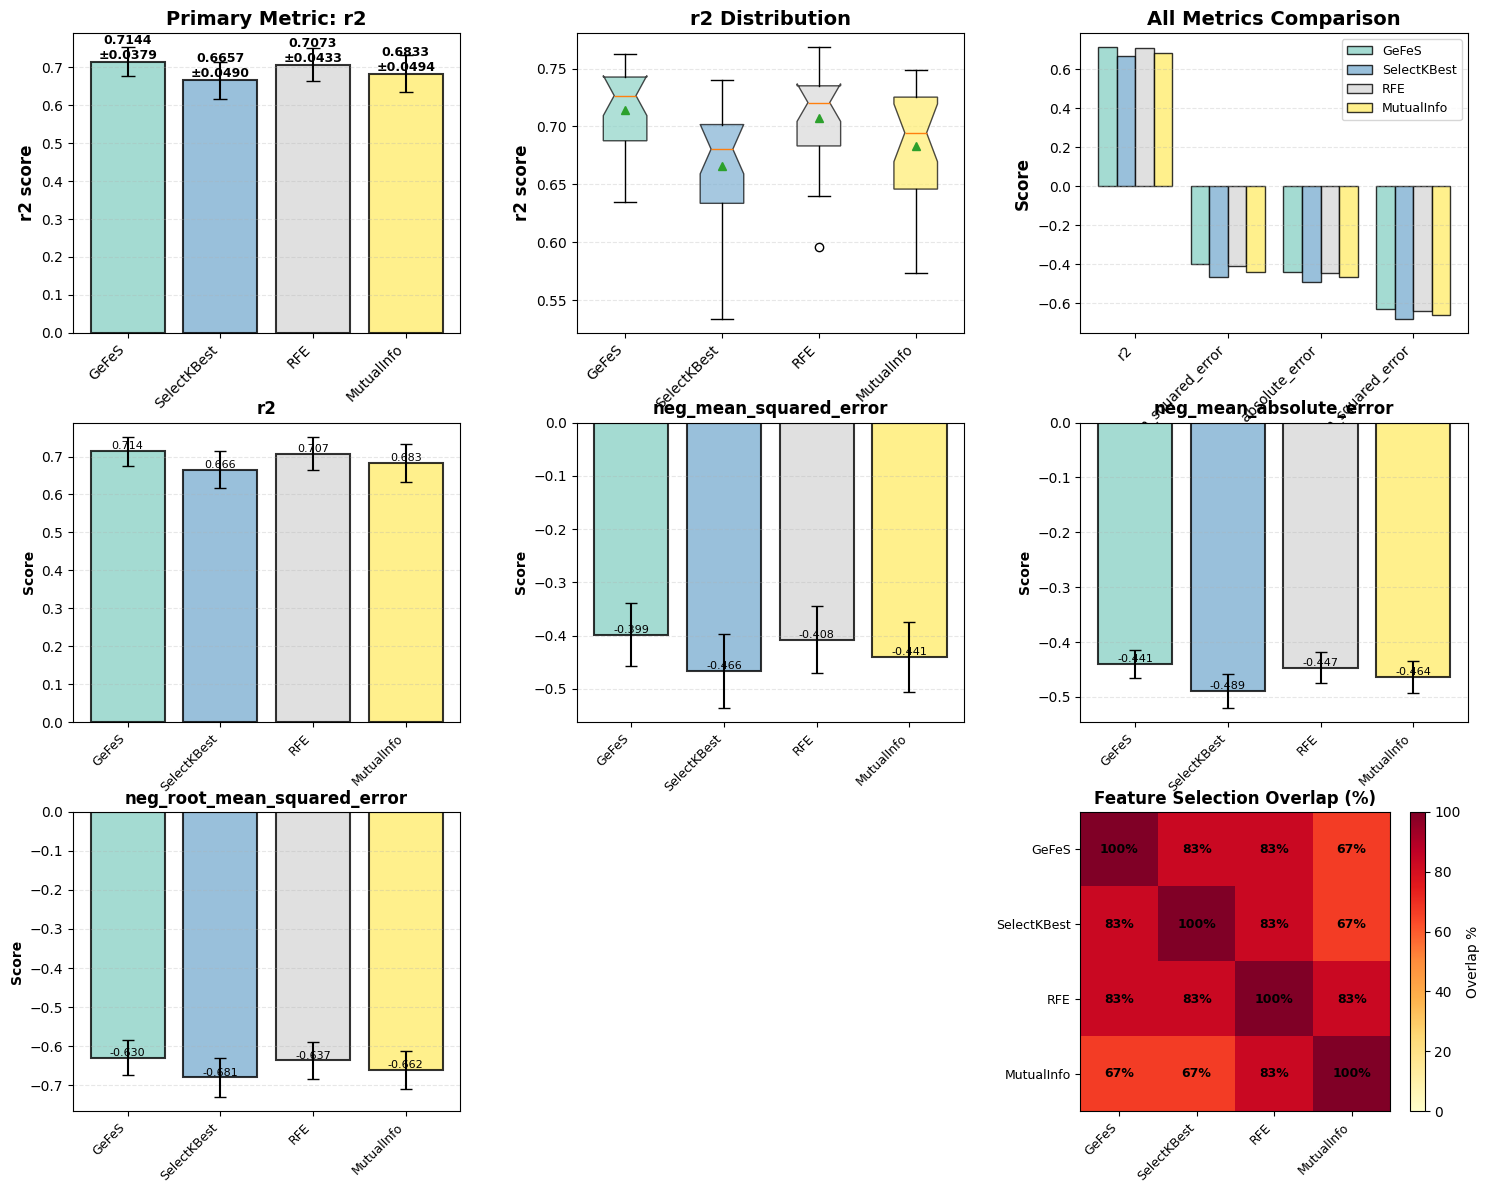


Regression analysis complete!


In [5]:
# ============================================================
# Regression Feature Selection Comparison Framework
# ============================================================

class RegressionFeatureSelectionComparison:
    """Compare multiple feature selection methods for regression."""

    def __init__(self, X, y, feature_names=None,
                 n_features_to_select=None,
                 estimator=None,
                 n_repeats=10,
                 cv_folds=5,
                 primary_metric='r2'):
        """
        Parameters:
        -----------
        X : array-like
            Feature matrix
        y : array-like
            Target vector (continuous)
        feature_names : list, optional
            Names of features
        n_features_to_select : int or None
            Target number of features to select. If None, will be set by GeFeS.
        estimator : sklearn estimator
            Base estimator for evaluation (regressor)
        n_repeats : int
            Number of repetitions for statistical testing
        cv_folds : int
            Number of cross-validation folds
        primary_metric : str
            Primary metric for comparison:
            one of ['r2', 'neg_mean_squared_error',
                    'neg_mean_absolute_error', 'neg_root_mean_squared_error']
        """
        self.X = X
        self.y = y
        self.feature_names = feature_names if feature_names is not None else \
            [f'Feature_{i}' for i in range(X.shape[1])]
        self.n_features_to_select = n_features_to_select
        self.estimator = estimator if estimator is not None else \
            RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
        self.n_repeats = n_repeats
        self.cv_folds = cv_folds
        self.primary_metric = primary_metric

        self.results = {}
        self.selected_features = {}
        self.scores_distribution = {}
        self.all_metrics_scores = {}
        self.gefes_n_features = None

    # ---------- GeFeS (GA) ----------

    def run_gefes(self):
        """Run GeFeS (Genetic Algorithm) feature selection for regression."""
        print("\n" + "=" * 60)
        print("Running GeFeS (Genetic Algorithm)...")
        print("=" * 60)

        # Decide optimization direction based on metric
        if self.primary_metric in [
            'neg_mean_squared_error',
            'neg_mean_absolute_error',
            'neg_root_mean_squared_error'
        ]:
            higher_is_better = False
        else:  # 'r2'
            higher_is_better = True

        selector = GeFeS(
            estimator=self.estimator,
            population_size=30,
            generations=50,
            crossover_rate=0.8,
            mutation_rate=0.1,
            elite_size=2,
            cv_folds=self.cv_folds,
            scoring=self.primary_metric,
            higher_is_better=higher_is_better,
            random_state=RANDOM_STATE,
            verbose=True
        )

        selector.fit(self.X, self.y, feature_names=self.feature_names)
        selected_features = selector.get_feature_names()

        # Fix the target number of features for other methods
        self.gefes_n_features = len(selected_features)
        self.n_features_to_select = self.gefes_n_features
        print(f"\n[GeFeS] Selected {self.gefes_n_features} features.")
        print("Other methods will be constrained to select the same number.\n")

        # Evaluate with repeated CV using multiple regression metrics
        all_metrics = self._evaluate_features_all_metrics(selector.best_features_)
        primary_scores = all_metrics[self.primary_metric]

        self.results['GeFeS'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            'best_score': selector.best_score_,
            **{f'{metric}_mean': np.mean(scores)
               for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores)
               for metric, scores in all_metrics.items()}
        }
        self.selected_features['GeFeS'] = selected_features
        self.scores_distribution['GeFeS'] = primary_scores
        self.all_metrics_scores['GeFeS'] = all_metrics

        print(f"GeFeS Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)
        print(f"  Top selected features: {', '.join(str(f) for f in selected_features[:8])}...")
        if len(selected_features) > 8:
            print(f"  ... and {len(selected_features) - 8} more")

    # ---------- Baseline methods ----------

    def run_selectkbest(self):
        """Run SelectKBest (univariate regression tests)."""
        print("\n" + "=" * 60)
        print("Running SelectKBest (f_regression)...")
        print("=" * 60)

        if self.n_features_to_select is None:
            raise ValueError("n_features_to_select is not set. "
                             "Run GeFeS first or specify a value.")

        selector = SelectKBest(score_func=f_regression,
                               k=self.n_features_to_select)
        selector.fit(self.X, self.y)

        selected_idx = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_idx]

        all_metrics = self._evaluate_features_all_metrics(selected_idx)
        primary_scores = all_metrics[self.primary_metric]

        self.results['SelectKBest'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            **{f'{metric}_mean': np.mean(scores)
               for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores)
               for metric, scores in all_metrics.items()}
        }
        self.selected_features['SelectKBest'] = selected_features
        self.scores_distribution['SelectKBest'] = primary_scores
        self.all_metrics_scores['SelectKBest'] = all_metrics

        print(f"\nSelectKBest Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)

    def run_rfe(self):
        """Run Recursive Feature Elimination for regression."""
        print("\n" + "=" * 60)
        print("Running RFE (Recursive Feature Elimination)...")
        print("=" * 60)

        if self.n_features_to_select is None:
            raise ValueError("n_features_to_select is not set. "
                             "Run GeFeS first or specify a value.")

        selector = RFE(
            estimator=RandomForestRegressor(
                n_estimators=50, random_state=RANDOM_STATE),
            n_features_to_select=self.n_features_to_select,
            step=1
        )
        selector.fit(self.X, self.y)

        selected_idx = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_idx]

        all_metrics = self._evaluate_features_all_metrics(selected_idx)
        primary_scores = all_metrics[self.primary_metric]

        self.results['RFE'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            **{f'{metric}_mean': np.mean(scores)
               for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores)
               for metric, scores in all_metrics.items()}
        }
        self.selected_features['RFE'] = selected_features
        self.scores_distribution['RFE'] = primary_scores
        self.all_metrics_scores['RFE'] = all_metrics

        print(f"\nRFE Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)

    def run_mutual_info(self):
        """Run Mutual Information feature selection for regression."""
        print("\n" + "=" * 60)
        print("Running Mutual Information Selection (regression)...")
        print("=" * 60)

        if self.n_features_to_select is None:
            raise ValueError("n_features_to_select is not set. "
                             "Run GeFeS first or specify a value.")

        selector = SelectKBest(score_func=mutual_info_regression,
                               k=self.n_features_to_select)
        selector.fit(self.X, self.y)

        selected_idx = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_idx]

        all_metrics = self._evaluate_features_all_metrics(selected_idx)
        primary_scores = all_metrics[self.primary_metric]

        self.results['MutualInfo'] = {
            'mean_score': np.mean(primary_scores),
            'std_score': np.std(primary_scores),
            'n_features': len(selected_features),
            **{f'{metric}_mean': np.mean(scores)
               for metric, scores in all_metrics.items()},
            **{f'{metric}_std': np.std(scores)
               for metric, scores in all_metrics.items()}
        }
        self.selected_features['MutualInfo'] = selected_features
        self.scores_distribution['MutualInfo'] = primary_scores
        self.all_metrics_scores['MutualInfo'] = all_metrics

        print(f"\nMutual Information Results:")
        print(f"  Selected {len(selected_features)} features")
        print(f"  Primary Metric ({self.primary_metric}): "
              f"{np.mean(primary_scores):.4f} ± {np.std(primary_scores):.4f}")
        self._print_all_metrics(all_metrics)

    # ---------- Helpers ----------

    def _print_all_metrics(self, all_metrics):
        """Print all metric scores."""
        for metric, scores in all_metrics.items():
            if metric != self.primary_metric:
                print(f"  {metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    def _evaluate_features_all_metrics(self, feature_indices):
        """Evaluate selected features using multiple regression metrics."""
        X_selected = self.X[:, feature_indices]

        cv = RepeatedKFold(
            n_splits=self.cv_folds,
            n_repeats=self.n_repeats,
            random_state=RANDOM_STATE
        )

        metrics = {
            'r2': 'r2',
            'neg_mean_squared_error': 'neg_mean_squared_error',
            'neg_mean_absolute_error': 'neg_mean_absolute_error',
            'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
        }

        all_scores = {}
        for metric_name, metric_scorer in metrics.items():
            scores = cross_val_score(
                self.estimator, X_selected, self.y,
                cv=cv, scoring=metric_scorer
            )
            all_scores[metric_name] = scores

        return all_scores

    # ---------- Orchestration ----------

    def run_all(self):
        """Run all feature selection methods."""
        self.run_gefes()
        self.run_selectkbest()
        self.run_rfe()
        self.run_mutual_info()

    def statistical_comparison(self):
        """Perform statistical significance tests between methods."""
        print("\n" + "=" * 60)
        print("STATISTICAL SIGNIFICANCE TESTING")
        print("=" * 60)

        methods = list(self.scores_distribution.keys())
        n_methods = len(methods)

        # Pairwise t-tests with Bonferroni correction
        print("\n1. Pairwise T-Tests (with Bonferroni correction):")
        print("-" * 60)

        n_comparisons = (n_methods * (n_methods - 1)) // 2
        alpha = 0.05
        bonferroni_alpha = alpha / n_comparisons

        comparison_results = []

        for i in range(n_methods):
            for j in range(i + 1, n_methods):
                method1, method2 = methods[i], methods[j]
                scores1 = self.scores_distribution[method1]
                scores2 = self.scores_distribution[method2]

                t_stat, p_value = stats.ttest_rel(scores1, scores2)
                mean_diff = np.mean(scores1) - np.mean(scores2)
                significant = p_value < bonferroni_alpha

                comparison_results.append({
                    'Method 1': method1,
                    'Method 2': method2,
                    'Mean Diff': mean_diff,
                    't-statistic': t_stat,
                    'p-value': p_value,
                    'Significant': 'Yes' if significant else 'No'
                })

                print(f"\n{method1} vs {method2}:")
                print(f"  Mean difference: {mean_diff:.4f}")
                print(f"  t-statistic: {t_stat:.4f}")
                print(f"  p-value: {p_value:.4e}")
                print(f"  Significant (α={bonferroni_alpha:.4f}): "
                      f"{'YES' if significant else 'NO'}")

        # Friedman test
        print("\n" + "-" * 60)
        print("2. Friedman Test (Non-parametric):")
        print("-" * 60)

        scores_array = np.array([self.scores_distribution[m] for m in methods])
        friedman_stat, friedman_p = stats.friedmanchisquare(*scores_array)

        print(f"  Chi-square statistic: {friedman_stat:.4f}")
        print(f"  p-value: {friedman_p:.4e}")
        print(f"  Significant difference exists: {'YES' if friedman_p < alpha else 'NO'}")

        # Effect sizes (Cohen's d)
        print("\n" + "-" * 60)
        print("3. Effect Sizes (Cohen's d):")
        print("-" * 60)

        for i in range(n_methods):
            for j in range(i + 1, n_methods):
                method1, method2 = methods[i], methods[j]
                scores1 = self.scores_distribution[method1]
                scores2 = self.scores_distribution[method2]

                mean_diff = np.mean(scores1) - np.mean(scores2)
                pooled_std = np.sqrt((np.var(scores1) + np.var(scores2)) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

                if abs(cohens_d) < 0.2:
                    interpretation = "negligible"
                elif abs(cohens_d) < 0.5:
                    interpretation = "small"
                elif abs(cohens_d) < 0.8:
                    interpretation = "medium"
                else:
                    interpretation = "large"

                print(f"\n{method1} vs {method2}:")
                print(f"  Cohen's d: {cohens_d:.4f} ({interpretation})")

        return comparison_results

    def plot_results(self):
        """Visualize comparison results for regression metrics."""
        fig = plt.figure(figsize=(18, 14))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        methods = list(self.results.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

        # 1. Bar plot of primary metric with error bars
        ax1 = fig.add_subplot(gs[0, 0])
        means = [self.results[m]['mean_score'] for m in methods]
        stds = [self.results[m]['std_score'] for m in methods]

        bars = ax1.bar(methods, means, yerr=stds, capsize=5,
                       color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
        ax1.set_ylabel(f'{self.primary_metric} score', fontsize=12, fontweight='bold')
        ax1.set_title(f'Primary Metric: {self.primary_metric}', fontsize=14, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2., height,
                     f'{mean:.4f}\n±{std:.4f}',
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

        # 2. Box plot of primary metric distributions
        ax2 = fig.add_subplot(gs[0, 1])
        score_data = [self.scores_distribution[m] for m in methods]
        bp = ax2.boxplot(score_data, labels=methods, patch_artist=True,
                         notch=True, showmeans=True)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax2.set_ylabel(f'{self.primary_metric} score', fontsize=12, fontweight='bold')
        ax2.set_title(f'{self.primary_metric} Distribution', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # 3. All metrics comparison
        ax3 = fig.add_subplot(gs[0, 2])
        metric_names = ['r2', 'neg_mean_squared_error',
                        'neg_mean_absolute_error', 'neg_root_mean_squared_error']
        x = np.arange(len(metric_names))
        width = 0.2

        for i, method in enumerate(methods):
            metric_means = [self.results[method][f'{m}_mean'] for m in metric_names]
            ax3.bar(x + i * width, metric_means, width, label=method,
                    color=colors[i], alpha=0.8, edgecolor='black', linewidth=1)

        ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax3.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
        ax3.set_xticks(x + width * (len(methods) - 1) / 2)
        ax3.set_xticklabels(metric_names, rotation=45, ha='right')
        ax3.legend(loc='best', fontsize=9)
        ax3.grid(axis='y', alpha=0.3, linestyle='--')

        # 4–7. Individual metric plots
        metric_positions = [(1, 0), (1, 1), (1, 2), (2, 0)]
        for idx, metric in enumerate(metric_names):
            row, col = metric_positions[idx]
            ax = fig.add_subplot(gs[row, col])

            metric_means = [self.results[m][f'{metric}_mean'] for m in methods]
            metric_stds = [self.results[m][f'{metric}_std'] for m in methods]

            bars = ax.bar(methods, metric_means, yerr=metric_stds, capsize=4,
                          color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
            ax.set_ylabel('Score', fontsize=10, fontweight='bold')
            ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)

            for bar, mean in zip(bars, metric_means):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                        f'{mean:.3f}', ha='center', va='bottom', fontsize=8)

        # 8. Feature overlap heatmap
        ax8 = fig.add_subplot(gs[2, 2])
        overlap_matrix = np.zeros((len(methods), len(methods)))

        for i, m1 in enumerate(methods):
            for j, m2 in enumerate(methods):
                if i == j:
                    overlap_matrix[i, j] = 100
                else:
                    features1 = set(self.selected_features[m1])
                    features2 = set(self.selected_features[m2])
                    overlap = len(features1.intersection(features2))
                    overlap_pct = (overlap / min(len(features1), len(features2))) * 100
                    overlap_matrix[i, j] = overlap_pct

        im = ax8.imshow(overlap_matrix, cmap='YlOrRd',
                        aspect='auto', vmin=0, vmax=100)
        ax8.set_xticks(np.arange(len(methods)))
        ax8.set_yticks(np.arange(len(methods)))
        ax8.set_xticklabels(methods, fontsize=9)
        ax8.set_yticklabels(methods, fontsize=9)
        plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45, ha='right')

        for i in range(len(methods)):
            for j in range(len(methods)):
                ax8.text(j, i, f'{overlap_matrix[i, j]:.0f}%',
                         ha="center", va="center",
                         color="black", fontweight='bold', fontsize=9)

        ax8.set_title('Feature Selection Overlap (%)',
                      fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax8, label='Overlap %')

        plt.savefig('regression_feature_selection_comparison.png',
                    dpi=300, bbox_inches='tight')
        print("\n✓ Plot saved as 'regression_feature_selection_comparison.png'")
        plt.show()

    def print_summary(self):
        """Print summary for regression comparison."""
        print("\n" + "=" * 60)
        print("FINAL SUMMARY (Regression)")
        print("=" * 60)

        primary_results = {method: {
            f'{self.primary_metric}_mean': self.results[method]['mean_score'],
            f'{self.primary_metric}_std': self.results[method]['std_score'],
            'n_features': self.results[method]['n_features']
        } for method in self.results.keys()}

        results_df = pd.DataFrame(primary_results).T
        # For 'r2', higher is better; for neg_*, higher (less negative) is also better
        results_df = results_df.sort_values(f'{self.primary_metric}_mean',
                                            ascending=False)

        print(f"\nPerformance Ranking (Primary Metric: {self.primary_metric}):")
        print(results_df.to_string())

        print("\nBest Method:", results_df.index[0])
        print(f"   {self.primary_metric}: "
              f"{results_df.iloc[0][f'{self.primary_metric}_mean']:.4f} "
              f"± {results_df.iloc[0][f'{self.primary_metric}_std']:.4f}")
        print(f"   Features: {int(results_df.iloc[0]['n_features'])}")

        print("\nAll Metrics Summary:")
        all_metrics_df = pd.DataFrame({
            method: {
                'R2': f"{self.results[method]['r2_mean']:.4f}",
                'Neg MSE': f"{self.results[method]['neg_mean_squared_error_mean']:.4f}",
                'Neg MAE': f"{self.results[method]['neg_mean_absolute_error_mean']:.4f}",
                'Neg RMSE': f"{self.results[method]['neg_root_mean_squared_error_mean']:.4f}",
            } for method in self.results.keys()
        }).T
        print(all_metrics_df.to_string())


def main_regression():
    """Main execution function for regression."""
    print("=" * 60)
    print("REGRESSION FEATURE SELECTION COMPARISON")
    print("=" * 60)

    # Load California Housing dataset
    print("\nLoading California Housing dataset...")
    data = fetch_california_housing()
    X_full, y_full = data.data, data.target
    feature_names = data.feature_names

    print(f"Full dataset size: {X_full.shape[0]} samples, {X_full.shape[1]} features")

    # Use a subset (e.g., 1000 samples) for speed
    X, _, y, _ = train_test_split(
        X_full, y_full,
        train_size=1000,
        random_state=RANDOM_STATE
    )

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"\nFinal dataset shape: {X_scaled.shape}")
    print(f"Number of samples: {X_scaled.shape[0]}")
    print(f"Number of features: {X_scaled.shape[1]}")

    print("\nTarget variable stats (median house value in 100k$):")
    print(f"  Mean:  {np.mean(y):.3f}")
    print(f"  Std:   {np.std(y):.3f}")
    print(f"  Min:   {np.min(y):.3f}")
    print(f"  Max:   {np.max(y):.3f}")

    # Choose primary metric for regression
    primary_metric = 'r2'
    print(f"\nUsing primary metric: {primary_metric}")
    print("Also tracking MSE, MAE, RMSE via their negative scorers.")

    comparison = RegressionFeatureSelectionComparison(
        X=X_scaled,
        y=y,
        feature_names=feature_names,
        n_features_to_select=None,  # will be set by GeFeS
        estimator=RandomForestRegressor(n_estimators=100,
                                        random_state=RANDOM_STATE),
        n_repeats=5,
        cv_folds=5,
        primary_metric=primary_metric
    )

    comparison.run_all()
    comparison.statistical_comparison()
    comparison.print_summary()
    comparison.plot_results()

    print("\n" + "=" * 60)
    print("Regression analysis complete!")
    print("=" * 60)


main_regression()